# Test PDE functionality on 2D Reaction-Diffusion system

I take this from PDEFIND exercise of PySINDy

This 2D system is significantly more complicated. The reaction-diffusion system exhibits spiral waves on a periodic domain,and the PDEs are:
$$u_t = 0.1\nabla^2 u + (1-A^2)u +\beta A^2v$$
$$v_t = 0.1\nabla^2 v - \beta A^2 u + (1-A^2)v$$
$$A^2 = u^2 + v^2.$$
The main change will be a significantly larger library... cubic terms in (u, v) and all their first and second order derivatives. We will also need to generate the data because saving a high-resolution form of the data makes a fairly large file.

cuda
CPU times: user 52.2 s, sys: 210 ms, total: 52.4 s
Wall time: 52.4 s


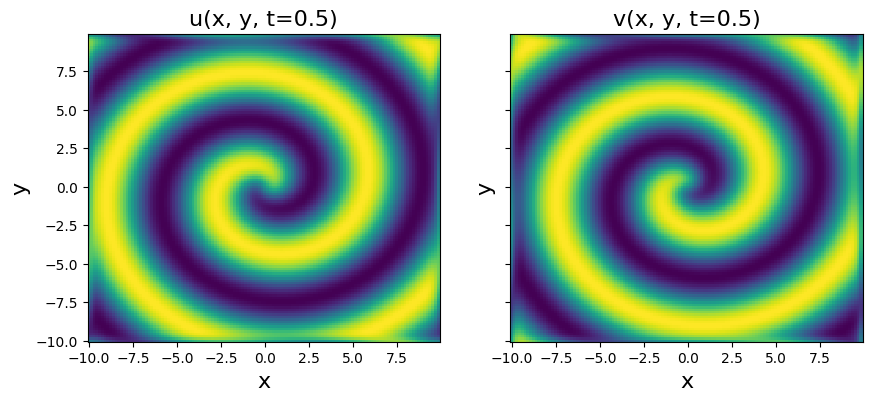

In [2]:
%%time
import numpy as np
import torch
import matplotlib.pyplot as plt

# Ignore matplotlib deprecation warnings
import warnings

warnings.filterwarnings("ignore", category=UserWarning)


# DeepMoD functions

from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.library import Library2D
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic

# PySINDy functions

import pysindy as ps
from numpy.fft import fft2, ifft2
from scipy.integrate import solve_ivp


# Seed the random number generators for reproducibility
np.random.seed(100)
torch.manual_seed(0)

# Configuring GPU or CPU
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)


integrator_keywords = {}
integrator_keywords["rtol"] = 1e-12
integrator_keywords["method"] = "LSODA"
integrator_keywords["atol"] = 1e-12
integrator_keywords["method"] = "RK45"  # switch to RK45 integrator


# Define the reaction-diffusion PDE in the Fourier (kx, ky) space
def reaction_diffusion(t, uvt, K22, d1, d2, beta, n, N):
    ut = np.reshape(uvt[:N], (n, n))
    vt = np.reshape(uvt[N : 2 * N], (n, n))
    u = np.real(ifft2(ut))
    v = np.real(ifft2(vt))
    u3 = u**3
    v3 = v**3
    u2v = (u**2) * v
    uv2 = u * (v**2)
    utrhs = np.reshape((fft2(u - u3 - uv2 + beta * u2v + beta * v3)), (N, 1))
    vtrhs = np.reshape((fft2(v - u2v - v3 - beta * u3 - beta * uv2)), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(
        np.vstack(
            (-d1 * K22 * uvt_reshaped[:N] + utrhs, -d2 * K22 * uvt_reshaped[N:] + vtrhs)
        )
    )
    return uvt_updated


# Generate the data
t = np.linspace(0, 10, int(10 / 0.05))
d1 = 0.1
d2 = 0.1
beta = 1.0
L = 20  # Domain size in X and Y directions
n = 128  # Number of spatial points in each direction
N = n * n
x_uniform = np.linspace(-L / 2, L / 2, n + 1)
x = x_uniform[:n]
y = x_uniform[:n]
n2 = int(n / 2)
# Define Fourier wavevectors (kx, ky)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), np.linspace(-n2, -1, n2)))
ky = kx
# Get 2D meshes in (x, y) and (kx, ky)
X, Y = np.meshgrid(x, y)
KX, KY = np.meshgrid(kx, ky)
K2 = KX**2 + KY**2
K22 = np.reshape(K2, (N, 1))

m = 1  # number of spirals

# define our solution vectors
u = np.zeros((len(x), len(y), len(t)))
v = np.zeros((len(x), len(y), len(t)))

# Initial conditions
u[:, :, 0] = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(
    m * np.angle(X + 1j * Y) - (np.sqrt(X**2 + Y**2))
)
v[:, :, 0] = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(
    m * np.angle(X + 1j * Y) - (np.sqrt(X**2 + Y**2))
)

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(
    np.hstack(
        (np.reshape(fft2(u[:, :, 0]), (1, N)), np.reshape(fft2(v[:, :, 0]), (1, N)))
    )
)

# Solve the PDE in the Fourier space, where it reduces to system of ODEs
uvsol = solve_ivp(
    reaction_diffusion,
    (t[0], t[-1]),
    y0=uvt0,
    t_eval=t,
    args=(K22, d1, d2, beta, n, N),
    **integrator_keywords
)
uvsol = uvsol.y

# Reshape things and ifft back into (x, y, t) space from (kx, ky, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n))
    vt = np.reshape(uvsol[N:, j], (n, n))
    u[:, :, j] = np.real(ifft2(ut))
    v[:, :, j] = np.real(ifft2(vt))

# Plot to check if spiral is nicely reproduced
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X, Y, u[:, :, 10])
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.title("u(x, y, t=0.5)", fontsize=16)
plt.subplot(1, 2, 2)
plt.pcolor(X, Y, v[:, :, 10])
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title("v(x, y, t=0.5)", fontsize=16)

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

u_sol = u
v_sol = v

In [3]:
def create_data():
    # time runs in the 3rd dimension, X runs in 2nd dimension and Y runs in 1st dimension
    X, Y, T = np.meshgrid(
        x, y, t
    )  # this means that data now is the of format where X and Y are permuted
    X = np.transpose(X, (1, 0, 2))
    Y = np.transpose(Y, (1, 0, 2))
    T = np.transpose(T, (1, 0, 2))
    usol = np.transpose(u_sol, (1, 0, 2))
    vsol = np.transpose(v_sol, (1, 0, 2))
    coords = torch.from_numpy(np.stack((T, X, Y), axis=-1))
    data = torch.from_numpy(np.stack((usol, vsol), axis=-1))
    # alternative way of providing the coordinates
    # coords = torch.from_numpy(np.transpose((t_v.flatten(), x_v.flatten(), y_v.flatten())))
    # data = torch.from_numpy(usol[:, :, :, 3].reshape(-1,1))
    print("The coodinates have shape {}".format(coords.shape))
    print("The data has shape {}".format(data.shape))
    return coords, data

In [43]:
dataset = Dataset(
    create_data,
    preprocess_kwargs={
        "noise_level": 0.00,
        "normalize_coords": False,
        "normalize_data": False,
    },
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 20000},
    device=device,
)

The coodinates have shape torch.Size([128, 128, 200, 3])
The data has shape torch.Size([128, 128, 200, 2])
Preprocessing data
Dataset is using device:  cuda


coords.shape = torch.Size([20000, 3]), data.shape = torch.Size([20000, 2]), np.sum(ix) = 418


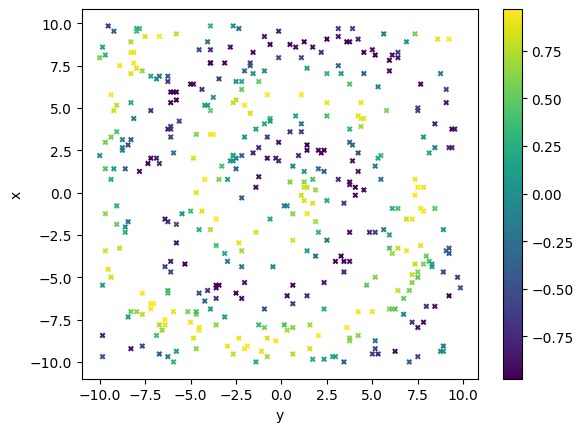

In [44]:
coords = dataset.get_coords().cpu()
data = dataset.get_data().cpu()
ix = (coords[:, 0].detach().cpu().numpy() > 0.4) & (
    coords[:, 0].detach().cpu().numpy() < 0.6
)
print(f"{coords.shape = }, {data.shape = }, {np.sum(ix) = }")


fig, ax = plt.subplots()
im = ax.scatter(coords[ix, 2], coords[ix, 1], c=data[ix, 0], marker="x", s=10)
ax.set_xlabel("y")
ax.set_ylabel("x")
fig.colorbar(mappable=im)

plt.show()

In [45]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

In [46]:
network = NN(3, [50, 50, 50, 50], 2)

In [54]:
library = Library2D(poly_order=1)  # Library function

In [55]:
estimator = Threshold(0.1)
sparsity_scheduler = TrainTestPeriodic()

In [56]:
constraint = LeastSquares()

In [57]:
model = DeepMoD(network, library, estimator, constraint).to(device)

In [58]:
# Defining optimizer
optimizer = torch.optim.Adam(
    model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3
)

In [59]:
%%time
foldername = "./data/deepymod/2DRD/"
train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    log_dir=foldername,
    max_iterations=100000,
    delta=1e-5,
    patience=200,
)

RuntimeError: mat1 and mat2 must have the same dtype

The issue must be that the library has only been designed for 2D systems with one degree of freedom